In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 16.1 Constrained least squares problem

- the (linearly) constrained least squares problem (CLS) is
$$
\begin{align}
 & \underset{}{\text{minimize}} && \|Ax-b\|^2 \\
 & \text{subject to} && Cx=d
\end{align}
$$
- variable (to be chosen/found) is n-vector $x$
- m × n matrix $A$, m-vector $b$, p × n matrix $C$, and p-vector $d$ are *problem data* (i.e., they are given)
- $\|Ax − b\|^2$ is the *objective function*
- $Cx = d$ are the *equality constraints*
- $x$ is feasible if $Cx = d$
- $\hat{x}$ is a solution of CLS if $C\hat{x} = d$ and $\|A\hat{x} − b\|^2 \le \|Ax − b\|^2$ holds for any n-vector $x$ that satisfies $Cx = d$

- CLS combines solving linear equations with least squares problem
- like a bi-objective least squares problem, with **infinite weight** on second objective $\|Cx − d\|^2$
$$ \|Ax − b\|^2 + \lambda \|Cx − d\|^2$$

## Piecewise polynomial

- piecewise-polynomial function $\hat{f}(x)$ has form
$$
\hat{f}(x) = \begin{cases}
p(x) = \theta_1 + \theta_2 x + \theta_3 x^2 + \theta_4 x^3 & x \le a \\
q(x) = \theta_5 + \theta_6 x + \theta_7 x^2 + \theta_8 x^3 & x \gt a \\
\end{cases}
$$
(a is given)
- we require $p(a) = q(a)$, $p'(a) = q'(a)$ \
  (i.e., $\hat{f}(x)$ is continuous and has a continuous first derivative at $x = a$)
- N data points $(x_i, y_i)$ are numbered: $x_1, \ldots , x_M \le a$ and $x_{M+1}, \ldots, x_N \gt a$
- sum of squares of the prediction errors
$$
\sum^M_{i=1}{(\theta_1 + \theta_2 x_i + \theta_3 x^2_i + \theta_4 x^3_i − y_i)^2} + \sum^N_{i=M+1}{(\theta_5 + \theta_6 x_i + \theta_7 x^2_i + \theta_8 x^3_i − y_i)^2}
$$
- constraints are (linear equations in $\theta$)
$$
\begin{align}
\theta_1 + \theta_2 a + \theta_3 a^2 + \theta_4 a^3 − \theta_5 + \theta_6 a + \theta_7 a^2 + \theta_8 a^3 &= 0 \\
\theta_2 + 2 \theta_3 a + 3 \theta_4 a^2 - \theta_6 + 2 \theta_7 a + 3 \theta_8 a^2 &= 0
\end{align}
$$
- prediction error on $(x_i, y_i)$ is $a^T_i \theta − y_i$, with
$$
(a_i)_j = \begin{cases}
(1, x_i, x_i^2, x_i^3, 0, 0, 0, 0) & x_i \le a \\
(0, 0, 0, 0, 1, x_i, x_i^2, x_i^3) & x_i \gt a
\end{cases}
$$
- sum square error is $\|A\theta − y\|^2$, where $a^T_i$ are rows of $A$

In [2]:
def cls_solve(A, b, C, d):

    # convert 1-d vector to 2-d column vector
    _ndim = b.ndim
    if _ndim == 1:
        b = np.vstack(b)
        d = np.vstack(d)

    m, n = A.shape
    p, n = C.shape
    Q, R = np.linalg.qr(np.vstack([A, C]))
    Q1 = Q[0:m, :]
    Q2 = Q[m:m+p, :]
    Qtil, Rtil = np.linalg.qr(Q2.T)
    w = np.linalg.lstsq(
        Rtil, 
        (2 * Qtil.T @ (Q1.T @ b) 
         - 2 * np.linalg.lstsq(Rtil.T, d, rcond=None)[0]),
        rcond=None
    )[0]
    xhat = np.linalg.lstsq(R, (Q1.T @ b - Q2.T @ w/2), rcond=None)[0]
    return xhat  # shape = (n, b.shape[1])

In [3]:
M = 70
N = 2 * M  # 140
xleft = np.random.random(M) - 1  # random floats in the half-open interval [-1, 0)
xright = np.random.random(M)  # random floats in the half-open interval [0, 1)

# x is in the [-1, 1) and shape is (140,)
x = np.hstack([xleft, xright])
# y = (x^3-x) + (0.4 / (1 + 25*x^2)) + (0.05*randn(N))
y = np.power(x, 3) - x + 0.4/(1+25*np.power(x, 2)) + 0.05*np.random.normal(size = N)

n = 4  # 3 degree polynomial
A = np.vstack(
    [np.hstack([np.vander(xleft, n, increasing=True), np.zeros((M, n))]),
     np.hstack([np.zeros((M, n)), np.vander(xright, n, increasing=True)])]
)
b = y
C = np.vstack(
    (np.hstack([1, np.zeros(n-1), -1, np.zeros(n-1)]),
     np.hstack([0, 1, np.zeros(n-2), 0, -1, np.zeros(n-2)]))
)
d = np.zeros(2)
theta = cls_solve(A, b, C, d)
theta

array([[ 0.30426299],
       [-1.1248426 ],
       [-2.00385254],
       [-0.66341426],
       [ 0.30426299],
       [-1.1248426 ],
       [-1.30393165],
       [ 2.21561482]])

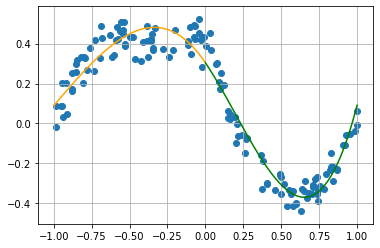

In [4]:
# Evaluate and plot for 200 equidistant points on each side.
Npl = 200
xpl_left = np.linspace(-1, 0, Npl)
ypl_left = np.vander(xpl_left, n, increasing=True) @ theta[:n]
xpl_right = np.linspace(0, 1, Npl)
ypl_right = np.vander(xpl_right, n, increasing=True) @ theta[n:]
plt.scatter(x, y)
plt.plot(xpl_left, ypl_left, 'orange')
plt.plot(xpl_right, ypl_right, 'green')
plt.grid()
plt.show()

## Advertising budget

$$
\begin{align}
&\text{minimize} & & \|Rs − v^{des}\|^2 \\
&\text{subject to} & & \mathbf{1}^Ts = B
\end{align}
$$
where $B$ is a given total advertising budget

In [5]:
m = 10
n = 3

R = np.array(
    [[0.97, 1.86, 0.41], [1.23, 2.18, 0.53],
     [0.80, 1.24, 0.62], [1.29, 0.98, 0.51],
     [1.10, 1.23, 0.69], [0.67, 0.34, 0.54],
     [0.87, 0.26, 0.62], [1.10, 0.16, 0.48],
     [1.92, 0.22, 0.71], [1.29, 0.12, 0.62]]
)
vdes = 1e3*np.ones(m)
B = np.array([1284])

cls_solve(R, vdes, np.ones((1, n)), B)

array([[315.16818459],
       [109.86643348],
       [858.96538193]])

## Least norm problem

- special case of constrained least squares problem, with $A = I$, $b = 0$
- least-norm problem:
$$
\begin{align}
    &\text{minimize} & & \|x\|^2 \\
    &\text{subject to} & & Cx = d
\end{align}
$$
    i.e., find the smallest vector that satisfies a set of linear equations

## Minimum norm force sequence

We compute the smallest sequence of ten forces, each applied for one second to a unit frictionless mass originally at rest, that moves the mass position one with zero velocity.
$$
\begin{align}
    &\text{minimize} & & \|f\|^2 \\
    &\text{subject to} & & 
    \begin{bmatrix} 
        1 & 1 & \cdots & 1 & 1 \\
        19/2 & 17/2 & \cdots & 3/2 & 1/2
    \end{bmatrix} =
    \begin{bmatrix}
        0 \\ 1
    \end{bmatrix}
\end{align}
$$

In [6]:
np.arange(9.5, 0.4, -1).T.shape

(10,)

In [7]:
A = np.eye(10)
b = np.zeros(10)
C = np.vstack([np.ones((1, 10)),
               np.arange(9.5, 0.4, -1)])
C

array([[1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [9.5, 8.5, 7.5, 6.5, 5.5, 4.5, 3.5, 2.5, 1.5, 0.5]])

In [8]:
d = np.array([0, 1])
cls_solve(A, b, C, d)

array([[ 0.05454545],
       [ 0.04242424],
       [ 0.03030303],
       [ 0.01818182],
       [ 0.00606061],
       [-0.00606061],
       [-0.01818182],
       [-0.03030303],
       [-0.04242424],
       [-0.05454545]])

# 16.2 Solution

## Optimality conditions via Lagrange multipliers (calculus)

to solve constrained least squares problem with the constraints given as a list of $p$ scalar equality constraints
$$
\begin{align}
    &\text{minimize} & & f(x)=\|Ax - b\|^2 \\
    &\text{subject to} & & c^T_i x = d_i, & i = 1, \ldots, p
\end{align}
$$
where $c^T_i$ are the rows of $C$

1. form the *Lagrangian function*, with *Lagrange multipliers* $z_1, \ldots, z_p$
$$
L(x, z) = f(x) + z_1(c^T_1 x − d_1) + \cdots + z_p(c^T_p x − d_p)
$$
2. *optimality conditions* (if $\hat{x}$ is a solution of the constrained least squares problem, then there is a set of Lagrange multipliers $\hat{z}$ that satisfy) for the constrained least squares problem
$$
\frac{\partial L}{\partial x_i}(\hat{x}, \hat{z}) = 0, \quad i = 1, \ldots, n, \qquad
\frac{\partial L}{\partial z_i}(\hat{x}, \hat{z}) = 0, \quad i = 1, \ldots, n
$$

- $\frac{\partial L}{\partial z_i}(\hat{x}, \hat{z}) = c^T_i \hat{x} − d_i = 0, \ i = 1, \ldots , p$, which we already knew
- The first set of equations is more informative
$$
\frac{\partial L}{\partial x_i}(\hat{x}, \hat{z}) = 2 \sum^n_{j=1}{(A^T A)_{ij} \hat{x}_j} − 2 (A^T b)_i + \sum^p_{j=1} \hat{z}_j (c_j)_i = 0.
$$
- in compact matrix-vector form
$$
2(A^T A) \hat{x} − 2A^T b + C^T \hat{z} = 0
$$
- put together with feasibility conditions $C\hat{x} = d$ to get Karush–Kuhn–Tucker (KKT) conditions
$$
\begin{bmatrix}
2A^T A & C^T \\
C & 0
\end{bmatrix}
\begin{bmatrix}
\hat{x} \\
\hat{z}
\end{bmatrix}
=\begin{bmatrix}
2A^T b \\
d
\end{bmatrix}$$
    a square set of n + p linear equations in variables $\hat{x}, \hat{z}$
- KKT equations are extension of normal equations to CLS

## Invertibility of KKT matrix

- (n + p) × (n + p) KKT matrix $\begin{bmatrix} 2A^T A & C^T \\ C & 0 \end{bmatrix}$ is invertible if and only if

    $C$ has linearly independent rows, and $\begin{bmatrix} A \\ C \end{bmatrix}$ has linearly independent columns

    1. The first condition requires that $C$ is wide (or square) ($p \le n$), i.e., that there are fewer constraints than variables.
    2. The second condition depends on both $A$ and $C$ ($m+p \ge  n$), and it can be satisfied even when the columns of $A$ are linearly dependent.
- assuming the KKT matrix is invertible, we have
$$
\begin{bmatrix}
\hat{x} \\
\hat{z}
\end{bmatrix}
=
\begin{bmatrix}
2A^T A & C^T \\
C & 0
\end{bmatrix}^{-1}
\begin{bmatrix}
2A^T b \\
d
\end{bmatrix}$$

## Direct verification of constrained least squares solution

- Suppose that $x \ne \hat{x}$ ($\hat{x}$ is solution) is any vector that satisfies $Cx = d$. We will show that $\|Ax − b\|^2 > \|A\hat{x} − b\|^2$.
- then 
$$
\begin{align}
\|Ax − b\|^2
&= \|(Ax − A\hat{x}) + (A\hat{x} − b)\|^2 \\
&= \|A(x − \hat{x})\|^2 + \|A\hat{x} − b\|^2 + 2(Ax − A\hat{x})^T (A\hat{x} − b)
\end{align}
$$

- expand last term, using $2A^T(A\hat{x} − b) = −C^Tz$, $Cx = C\hat{x} = d$:
$$
\begin{align}
2(Ax − A\hat{x})^T (A\hat{x} − b)
&= 2(x − \hat{x})^T A^T(A\hat{x} − b) \\
&= −(x − \hat{x})^T C^T \hat{z} \\
&= −(C(x − \hat{x}))^T \hat{z} \\
&= 0
\end{align}
$$

- so $\|Ax − b\|^2 = \|A(x − \hat{x})\|^2 + \|A\hat{x} − b\|^2 \ge \|A\hat{x} − b\|^2$
- and we conclude $\hat{x}$ is solution

Let's implement the function `cls_solve_kkt`, which finds the constrained least squares solution by forming the KKT system and solving it.

We allow the $b$ and $d$ to be **matrices**, so one function call can solve **multiple problems** with the same $A$ and $C$.

In [9]:
def cls_solve_kkt(A, b, C, d):

    # convert 1-d vector to 2-d column vector
    _ndim = b.ndim
    if _ndim == 1:
        b = np.vstack(b)
        d = np.vstack(d)

    m, n = A.shape
    p, n = C.shape
    G = A.T @ A  # Gram matrix
    # KKT matrix
    KKT = np.vstack(
        [np.hstack([2*G, C.T]),
         np.hstack([C, np.zeros((p, p))])]
    )
    xzhat = np.vstack(
        np.linalg.lstsq(KKT, np.vstack([2*A.T @ b, d]), rcond=None)[0]
    )
    return xzhat[0:n, :]  # shape = (n, b.shape[1])

In [10]:
A = np.random.normal(size = (10, 5))
b = np.random.normal(size = 10)
C = np.random.normal(size = (2, 5))
d = np.random.normal(size = 2)
x = cls_solve_kkt(A, b, C, d)
# Check that residual is small
print(C @ x - np.vstack(d))

[[ 9.71445147e-16]
 [-1.99840144e-15]]


In [11]:
A = np.random.normal(size = (10, 5))
b = np.random.normal(size = (10, 2))
C = np.random.normal(size = (2, 5))
d = np.random.normal(size = (2, 2))
x = cls_solve_kkt(A, b, C, d)
# Check that residual is small
print(C @ x - np.vstack(d))

[[-8.88178420e-16 -3.15025783e-15]
 [ 1.72084569e-15  1.55431223e-15]]


# 16.3 Solving constrained least squares problems

**Algorithm** Constrained least squares via KKT equations

**given** an m × n matrix $A$ and a p × n matrix $C$ that satisfy the invertible condition of KKT matrix, an m-vector $b$, and a p-vector $d$.
1. Form Gram matrix. Compute $A^T A$.
2. Solve KKT equations. Solve KKT equations by QR factorization and back substitution.

---
complexity
- Form Gram matrix: $mn^2$ flops
- Solve KKT equations: $2(n + p)^3$ flops
- Total $mn^2 + 2(n + p)^3$ flops; order is $n^3$ flops (Assuming $p \le n$)

## Solving constrained least squares problems via QR factorization

- rewriting the KKT equations
$$\begin{align}
2(A^T A) \hat{x} + C^T \hat{z} &= 2A^T b, & C\hat{x} &= d \\
2(A^T A) \hat{x} + 2(C^T C \hat{x}) - 2(C^T C \hat{x}) + C^T \hat{z} &= 2A^T b, & C\hat{x} &= d \\
2(A^T A) \hat{x} + 2(C^T C) \hat{x} - 2(C^T d) + C^T \hat{z} &= 2A^T b, & C\hat{x} &= d \\
2(A^T A + C^T C) \hat{x} - 2(C^T d) + C^T \hat{z} &= 2A^T b, & C\hat{x} &= d \\
2(A^T A + C^T C) \hat{x} + C^T (\hat{z} - 2d) &= 2A^T b, & C\hat{x} &= d \\
2(A^T A + C^T C) \hat{x} + C^T w &= 2A^T b, & C\hat{x} &= d
\end{align}
$$

- use the QR factorization to simplify equations (factorization exists because the stacked matrix has linearly independent columns)
$$
\begin{bmatrix}
A \\ C
\end{bmatrix}
= QR = 
\begin{bmatrix}
Q_1 \\ Q_2
\end{bmatrix}
R
$$
    make the substitutions $A = Q_1R$, $C = Q_2R$, and $A^T A + C^T C = R^T R$
$$
2(R^T R) \hat{x} + R^T Q_2^T w = 2 R^T Q_1^T b, \quad Q_2R\hat{x} = d
$$

- multiply the first equation on the left by $R^{−T}$ (which we know exists)
$$
\begin{align}
2(R^{−T} R^T R) \hat{x} + R^{−T} R^T Q_2^T w &= 2 R^{−T} R^T Q_1^T b \\
2 R \hat{x} + Q_2^T w &= 2 Q_1^T b \\
R \hat{x} &= Q_1^T b - \frac{1}{2} Q_2^T w
\end{align}
$$
    Substituting expression into $Q_2 R\hat{x} = d$ gives an equation in $w$
$$
\begin{align}
R \hat{x} &= Q_1^T b - \frac{1}{2} Q_2^T w \\
Q_2^T w &= 2 Q_1^T b - 2 R \hat{x} \\
Q_2^T w &= 2 Q_1^T b - 2 Q_2^{-1} d \\
Q_2 Q_2^T w &= 2 Q_2 Q_1^T b - 2 d
\end{align}
$$

- Based on the assumption that $C$ has linearly independent rows,
$$
\begin{align}
\text{Suppose} \quad Q^T_2 z = R^{−T} C^T z &= 0 \\
R^T R^{−T} C^T z &= 0 \\
C^T z &= 0 \\
z &= 0 \quad \text{(because $C^T$ has linearly independent columns)}
\end{align}
$$
    we can conclude that the columns of $Q^T_2$ are linearly independent.
    
- The matrix $Q^T_2$ therefore has a QR factorization $Q^T_2 = \tilde{Q}\tilde{R}$.
$$
\begin{align}
Q_2 Q_2^T w &= 2 Q_2 Q_1^T b - 2 d \\
\tilde{R}^T\tilde{Q}^T \tilde{Q}\tilde{R} w &= 2 \tilde{R}^T\tilde{Q}^T Q_1^T b - 2 d \\
\tilde{R}^T \tilde{R} w &= 2 \tilde{R}^T\tilde{Q}^T Q_1^T b - 2 d \\
\tilde{R} w &= 2 \tilde{Q}^T Q_1^T b - 2 \tilde{R}^{-T} d \\
\end{align}
$$
    First, form RHS by computing $\tilde{R}^{−T} d$ (by forward substitution), and then solving for $w$ using back substitution.

- Once we know $w$, we can find $\hat{x}$ from $R \hat{x} = Q_1^T b - \frac{1}{2} Q_2^T w$

**Algorithm**  Constrained least squares via QR factorization
**given** an m × n matrix $A$ and a p × n matrix $C$ that satisfy the invertible condition of KKT matrix, an m-vector $b$,
and a p-vector $d$.
1. QR factorizations. Compute the QR factorizations 
$$\begin{bmatrix} A \\ C \end{bmatrix} = \begin{bmatrix} Q_1 \\ Q_2 \end{bmatrix} R, \quad Q^T_2 = \tilde{Q}\tilde{R}$$.

2. Compute $\tilde{R}^{−T} d$ by forward substitution.
3. Form right-hand side and solve
$$\tilde{R} w = 2\tilde{Q}^T Q^T_1 b − 2\tilde{R}^{−T}d$$
via back substitution.
4. Compute \hat{x}. Form right-hand side and solve
$$R \hat{x} = Q_1^T b - \frac{1}{2} Q_2^T w$$
by back substitution.

---
complexity
1. QR factorizations of an (m + p) × n and an n × p matrix, which costs $2(m + p)n^2 + 2np^2$ flops.
2. solve $\tilde{R}^{−T} d$ require $p^2$ flops.
3. evaluate $Q^T_1 b$ require $2mn$ flops \
   multiply the result by $\tilde{Q}^T$ require $2pn$ flops \
   solve $w$ require $p^2$ flops
4. $2mn+ 2pn$ flops to form the right-hand side, $n^2$ flops to compute $\hat{x}$


- Total complexity is $2(m + p)n^2 + 2np^2$.

- The invertible condition of KKT matrix implies the inequalities
$$p ≤ n ≤ m + p$$,
    and therefore $(m+p)n^2 \ge np^2$
- flop count above is no more than $4(m+p)n^2$ flops. order is $(m + p)n^2$.

In [12]:
def cls_solve(A, b, C, d):

    # convert 1-d vector to 2-d column vector
    _ndim = b.ndim
    if _ndim == 1:
        b = np.vstack(b)
        d = np.vstack(d)

    m, n = A.shape
    p, n = C.shape
    Q, R = np.linalg.qr(np.vstack([A, C]))
    Q1 = Q[0:m, :]
    Q2 = Q[m:m+p, :]
    Qtil, Rtil = np.linalg.qr(Q2.T)
    w = np.linalg.lstsq(
        Rtil, 
        (2 * Qtil.T @ (Q1.T @ b) 
         - 2 * np.linalg.lstsq(Rtil.T, d, rcond=None)[0]),
        rcond=None
    )[0]
    xhat = np.linalg.lstsq(R, (Q1.T @ b - Q2.T @ w/2), rcond=None)[0]
    return xhat  # shape = (n, b.shape[1])


# compare with KKT method
m = 10
n = 5
p = 2
A = np.random.normal(size = (m,n))
b = np.random.normal(size = m)
C = np.random.normal(size = (p,n))
d = np.random.normal(size = p)
xKKT = cls_solve_kkt(A, b, C, d)
xQR = cls_solve(A, b, C, d)
# compare solutions
print(np.linalg.norm(xKKT - xQR))

5.99006220634744e-15


## Sparse constrained least squares

- $A$ and $C$ are sparse
- but Gram matrix $A^T A$ can be far less sparse
$$
\begin{bmatrix}
2A^T A & C^T \\
C & 0
\end{bmatrix}
\begin{bmatrix}
\hat{x} \\
\hat{z}
\end{bmatrix}
=\begin{bmatrix}
2A^T b \\
d
\end{bmatrix}$$

- To avoid above problem, we form the m+n+p sparse matrix
$$
\begin{bmatrix}
0 & A^T & C^T \\
A & −(1/2)I & 0 \\
C & 0 & 0
\end{bmatrix}
\begin{bmatrix}
\hat{x} \\
\hat{y} \\
\hat{z}
\end{bmatrix}
=
\begin{bmatrix}
0 \\
b \\
d
\end{bmatrix}
$$

(The code below just checks that the two methods agree; it does not use sparsity. Unlike
the earlier `cls_solve`, it assumes $b$ and $d$ are vectors.)

In [13]:
def cls_solve_sparse(A, b, C, d):
    
    # convert 1-d vector to 2-d column vector
    _ndim = b.ndim
    if _ndim == 1:
        b = np.vstack(b)
        d = np.vstack(d)
        
    m, n = A.shape
    p, n = C.shape
    bigA = np.vstack([np.hstack([np.zeros((n, n)), A.T, C.T]),
                      np.hstack([A, -np.eye(m)/2, np.zeros((m, p))]),
                      np.hstack([C, np.zeros((p,m)), np.zeros((p,p))])])
    
    xyzhat = np.linalg.lstsq(bigA, np.vstack([np.zeros((n, _ndim)), b, d]), rcond=None)[0]
    return xyzhat[0:n]  # shape = (n, b.shape[1])


m = 100
n = 50
p = 10
A = np.random.normal(size = (m,n))
b = np.random.normal(size = m)
C = np.random.normal(size = (p,n))
d = np.random.normal(size = p)
x1 = cls_solve(A, b, C, d)
x2 = cls_solve_sparse(A, b, C, d)
# compare solutions
print(np.linalg.norm(x1 - x2))

1.0989198152982415e-14


## Solution of least norm problem

- least-norm problem: minimize $\|x\|^2$ subject to $Cx = d$
- matrix $\begin{bmatrix} I \\ C \end{bmatrix}$ always has independent columns
- we assume that $C$ has independent rows
- optimality condition reduces to
$$
\begin{bmatrix}
2I & C^T \\
C & 0
\end{bmatrix}
\begin{bmatrix}
\hat{x} \\
\hat{z}
\end{bmatrix}
=\begin{bmatrix}
0 \\
d
\end{bmatrix}$$
- so $\hat{x} = −(1/2)C^T\hat{z}$; second equation is then $−(1/2)CC^T\hat{z} = d$
- plug $\hat{z} = −2(CC^T)^{−1}d$ into first equation to get 
$$
\hat{x} = C^T(CC^T)^{−1} d = C^\dagger
$$
    where $C^\dagger$ is the pseudo-inverse

so when $C$ has linearly independent rows:
- $C^\dagger$ is a right inverse of $C$
- so for any $d$, $\hat{x} = C^\dagger d$ satisfies $C\hat{x} = d$
- and we now know: $\hat{x}$ is the smallest solution of $Cx = d$

In [14]:
p = 50
n = 500
C = np.random.normal(size=(p, n))
d = np.random.normal(size=p)

# solve via least norm analytical solution
x1 = C.T @ np.linalg.inv(C @ C.T) @ d

# solve using cls_solve which uses KKT
x2 = cls_solve(np.eye(n), np.zeros(n), C, d)

# Using pseudo inverse
x3 = np.linalg.pinv(C) @ d

print(np.linalg.norm(np.vstack(x1) - x2))
print(np.linalg.norm(x2 - np.vstack(x3)))

3.822050000182817e-15
4.027280236394221e-15
